In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tqdm import tqdm

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier


In [157]:
sig_df = pd.read_pickle(Path('/Users/Ethan/Documents/UW417/Doubly Charged Higgs Search/Edited Notebooks/NewSignalFeatures.pkl'))
sig_df["target"] = 1
bkg_df = pd.read_pickle(Path('/Users/Ethan/Documents/UW417/Doubly Charged Higgs Search/Edited Notebooks/NewBackgroundFeatures.pkl'))
bkg_df["target"] = 0

In [158]:
combined_df = pd.concat([bkg_df, sig_df], ignore_index=True)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

In [170]:
for feature in combined_df.columns[:13]:
    roc_score = roc_auc_score(y_true=combined_df["target"], y_score=combined_df[feature])
    print(f"{feature}: {roc_score:.4f}")

jet1_pt_NOSYS: 0.3027
jet2_pt_NOSYS: 0.2858
mjj_NOSYS: 0.5683
dEta_jj_NOSYS: 0.7051
Et_ll_NOSYS: 0.4507
H_t_NOSYS: 0.3227
MT_dilep_NOSYS: 0.4408
pt_ll_NOSYS: 0.4300
mll_NOSYS: 0.4923
weight_mc_NOSYS: 0.0035
mu_pt_NOSYS: 0.5132
el_e_NOSYS: 0.4787
jet_n_NOSYS: 0.4080


In [160]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_df.drop(columns=["weight_mc_NOSYS", "target"]),
    combined_df["target"],
    test_size=0.2,
    random_state=42,
)

In [161]:
X_train

,jet1_pt_NOSYS,jet2_pt_NOSYS,mjj_NOSYS,dEta_jj_NOSYS,Et_ll_NOSYS,H_t_NOSYS,MT_dilep_NOSYS,pt_ll_NOSYS,mll_NOSYS,mu_pt_NOSYS,el_e_NOSYS,jet_n_NOSYS,bjet_n_NOSYS
13728,195529.984375,106094.812500,2.515842e+05,1.428566,175825.296875,6.757441e+05,201141.484375,93725.078125,148762.046875,129912.718750,79780.031250,4,0
20091,253216.156250,240389.000000,1.062916e+06,2.845183,302459.937500,7.759944e+05,304035.750000,197947.265625,228689.515625,167879.484375,139366.343750,2,0
20511,433140.750000,405770.718750,1.093177e+06,1.517437,230626.781250,1.432956e+06,101696.843750,221359.875000,64718.761719,168429.750000,61320.039062,3,0
31486,178879.343750,40736.382812,7.253956e+04,0.709164,561377.500000,1.029288e+06,563879.312500,299422.718750,474858.625000,52652.777344,379614.656250,4,0
12432,296475.593750,88017.093750,3.326695e+05,0.622765,111396.742188,6.347797e+05,160366.656250,52768.160156,98105.835938,61656.226562,31004.425781,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,316027.375000,104396.585938,5.872564e+05,2.140689,80665.359375,5.907260e+05,192007.812500,29033.042969,75259.437500,51520.738281,29213.994141,2,0
5390,108886.515625,57924.820312,7.181036e+05,4.377186,111396.625000,3.468319e+05,132748.078125,84439.695312,72657.726562,53822.648438,87363.359375,2,0
860,162878.000000,68342.046875,8.238014e+05,4.077383,191902.390625,5.666376e+05,305506.312500,40108.750000,187664.093750,73806.031250,174385.171875,3,0
15795,165401.328125,120488.710938,9.626827e+05,3.792923,130317.750000,6.103666e+05,216367.156250,49153.128906,120692.531250,81118.398438,63238.386719,4,0


In [162]:
import xgboost as xgb
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer


In [163]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import xgboost as xgb

# Expanded hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),  # ~ [0.006, 0.36]
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 200, 1000, 50),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),  # L1 regularization
    'reg_lambda': hp.uniform('reg_lambda', 0, 10)  # L2 regularization
}


In [164]:
def objective(params):
    # Convert float parameters
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])
    
    model = xgb.XGBClassifier(
        **params,
        use_label_encoder=False,
        eval_metric='auc',
        n_jobs=1,  # safer on macOS
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    return {'loss': -auc, 'status': STATUS_OK}


In [165]:
import random
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=200,  # Try increasing to 200+ for better results
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Best hyperparameters:")
print(best)


  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  0%|          | 1/200 [00:00<01:25,  2.33trial/s, best loss: -0.8837966300661977]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  1%|          | 2/200 [00:00<01:07,  2.93trial/s, best loss: -0.8837966300661977]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  2%|▏         | 3/200 [00:01<01:03,  3.10trial/s, best loss: -0.8837966300661977]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  2%|▏         | 4/200 [00:01<01:40,  1.95trial/s, best loss: -0.8845479513881545]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  2%|▎         | 5/200 [00:02<01:31,  2.12trial/s, best loss: -0.8859442698594296]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  3%|▎         | 6/200 [00:02<01:33,  2.08trial/s, best loss: -0.8859442698594296]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  4%|▎         | 7/200 [00:04<03:13,  1.01s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  4%|▍         | 8/200 [00:05<02:44,  1.17trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  4%|▍         | 9/200 [00:05<02:20,  1.36trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  5%|▌         | 10/200 [00:07<03:01,  1.05trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  6%|▌         | 11/200 [00:08<03:00,  1.05trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  6%|▌         | 12/200 [00:08<02:22,  1.32trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  6%|▋         | 13/200 [00:09<02:11,  1.42trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  7%|▋         | 14/200 [00:09<02:09,  1.43trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  8%|▊         | 15/200 [00:10<02:27,  1.25trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  8%|▊         | 16/200 [00:11<01:58,  1.55trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  8%|▊         | 17/200 [00:11<01:59,  1.53trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  9%|▉         | 18/200 [00:12<02:17,  1.33trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 10%|▉         | 19/200 [00:13<01:57,  1.54trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 10%|█         | 20/200 [00:13<01:39,  1.81trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 10%|█         | 21/200 [00:15<02:36,  1.14trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 11%|█         | 22/200 [00:17<03:34,  1.20s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 12%|█▏        | 23/200 [00:18<03:40,  1.24s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 12%|█▏        | 24/200 [00:20<04:20,  1.48s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 12%|█▎        | 25/200 [00:21<03:38,  1.25s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 13%|█▎        | 26/200 [00:23<04:11,  1.45s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 14%|█▎        | 27/200 [00:24<04:08,  1.43s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 14%|█▍        | 28/200 [00:25<04:07,  1.44s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 14%|█▍        | 29/200 [00:27<03:51,  1.35s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 15%|█▌        | 30/200 [00:27<03:14,  1.14s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 16%|█▌        | 31/200 [00:29<03:25,  1.22s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 16%|█▌        | 32/200 [00:29<03:01,  1.08s/trial, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 16%|█▋        | 33/200 [00:30<02:25,  1.14trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 17%|█▋        | 34/200 [00:30<02:12,  1.25trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 18%|█▊        | 35/200 [00:31<02:16,  1.21trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 18%|█▊        | 36/200 [00:32<02:33,  1.07trial/s, best loss: -0.8870883396558243]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 18%|█▊        | 37/200 [00:34<03:21,  1.24s/trial, best loss: -0.8872619301417639]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 19%|█▉        | 38/200 [00:36<03:28,  1.29s/trial, best loss: -0.8872619301417639]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 20%|█▉        | 39/200 [00:36<02:47,  1.04s/trial, best loss: -0.8872619301417639]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 20%|██        | 40/200 [00:37<02:45,  1.04s/trial, best loss: -0.8872619301417639]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 20%|██        | 41/200 [00:39<02:57,  1.12s/trial, best loss: -0.8872619301417639]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 21%|██        | 42/200 [00:41<03:32,  1.35s/trial, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 22%|██▏       | 43/200 [00:42<03:40,  1.40s/trial, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 22%|██▏       | 44/200 [00:43<03:23,  1.31s/trial, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 22%|██▎       | 45/200 [00:44<02:56,  1.14s/trial, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 23%|██▎       | 46/200 [00:44<02:18,  1.11trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 24%|██▎       | 47/200 [00:45<01:57,  1.30trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 24%|██▍       | 48/200 [00:45<01:37,  1.56trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 24%|██▍       | 49/200 [00:46<01:45,  1.44trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 25%|██▌       | 50/200 [00:46<01:36,  1.55trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 26%|██▌       | 51/200 [00:47<01:30,  1.65trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 26%|██▌       | 52/200 [00:47<01:20,  1.84trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 26%|██▋       | 53/200 [00:48<01:19,  1.84trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 27%|██▋       | 54/200 [00:48<01:18,  1.85trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 28%|██▊       | 55/200 [00:49<01:11,  2.03trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 28%|██▊       | 56/200 [00:49<01:21,  1.78trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 28%|██▊       | 57/200 [00:50<01:15,  1.90trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 29%|██▉       | 58/200 [00:50<01:06,  2.14trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 30%|██▉       | 59/200 [00:51<01:22,  1.72trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 30%|███       | 60/200 [00:51<01:11,  1.96trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 30%|███       | 61/200 [00:52<01:09,  2.00trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 31%|███       | 62/200 [00:52<01:01,  2.24trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 32%|███▏      | 63/200 [00:53<01:01,  2.21trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 32%|███▏      | 64/200 [00:53<01:01,  2.21trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 32%|███▎      | 65/200 [00:54<01:18,  1.72trial/s, best loss: -0.8877208599889661]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 33%|███▎      | 66/200 [00:55<01:33,  1.43trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 34%|███▎      | 67/200 [00:56<01:31,  1.45trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 34%|███▍      | 68/200 [00:56<01:25,  1.54trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 34%|███▍      | 69/200 [00:57<01:25,  1.54trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 35%|███▌      | 70/200 [00:58<01:29,  1.45trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 36%|███▌      | 71/200 [00:59<01:40,  1.28trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 36%|███▌      | 72/200 [01:00<01:48,  1.18trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 36%|███▋      | 73/200 [01:00<01:47,  1.19trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 37%|███▋      | 74/200 [01:01<01:39,  1.26trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 38%|███▊      | 75/200 [01:02<01:26,  1.45trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 38%|███▊      | 76/200 [01:02<01:21,  1.52trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 38%|███▊      | 77/200 [01:03<01:20,  1.52trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 39%|███▉      | 78/200 [01:03<01:19,  1.54trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 40%|███▉      | 79/200 [01:04<01:20,  1.49trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 40%|████      | 80/200 [01:05<01:25,  1.40trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 40%|████      | 81/200 [01:05<01:13,  1.61trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 41%|████      | 82/200 [01:06<01:26,  1.37trial/s, best loss: -0.8880829588932304]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 42%|████▏     | 83/200 [01:07<01:23,  1.41trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 42%|████▏     | 84/200 [01:08<01:15,  1.54trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 42%|████▎     | 85/200 [01:08<01:06,  1.74trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 43%|████▎     | 86/200 [01:09<01:09,  1.65trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 44%|████▎     | 87/200 [01:09<01:01,  1.82trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 44%|████▍     | 88/200 [01:10<01:03,  1.75trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 44%|████▍     | 89/200 [01:10<01:00,  1.83trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 45%|████▌     | 90/200 [01:11<01:01,  1.79trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 46%|████▌     | 91/200 [01:12<01:15,  1.44trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 46%|████▌     | 92/200 [01:12<01:10,  1.54trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 46%|████▋     | 93/200 [01:13<01:00,  1.76trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 47%|████▋     | 94/200 [01:13<00:56,  1.86trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 48%|████▊     | 95/200 [01:14<01:07,  1.56trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 48%|████▊     | 96/200 [01:15<01:16,  1.36trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 48%|████▊     | 97/200 [01:15<01:07,  1.53trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 49%|████▉     | 98/200 [01:16<01:01,  1.66trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 50%|████▉     | 99/200 [01:17<01:10,  1.43trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 50%|█████     | 100/200 [01:17<01:06,  1.51trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 50%|█████     | 101/200 [01:18<01:05,  1.52trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 51%|█████     | 102/200 [01:19<01:03,  1.55trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 52%|█████▏    | 103/200 [01:19<01:05,  1.49trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 52%|█████▏    | 104/200 [01:20<01:06,  1.44trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 52%|█████▎    | 105/200 [01:21<00:54,  1.74trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 53%|█████▎    | 106/200 [01:21<00:51,  1.81trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 54%|█████▎    | 107/200 [01:22<00:52,  1.76trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 54%|█████▍    | 108/200 [01:23<01:03,  1.45trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 55%|█████▍    | 109/200 [01:23<01:04,  1.40trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:59:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 55%|█████▌    | 110/200 [01:25<01:16,  1.17trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 56%|█████▌    | 111/200 [01:25<01:14,  1.19trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 56%|█████▌    | 112/200 [01:27<01:23,  1.05trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 56%|█████▋    | 113/200 [01:27<01:17,  1.13trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 57%|█████▋    | 114/200 [01:28<01:09,  1.24trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 57%|█████▊    | 115/200 [01:29<01:14,  1.14trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 58%|█████▊    | 116/200 [01:30<01:13,  1.15trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 58%|█████▊    | 117/200 [01:31<01:21,  1.01trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 59%|█████▉    | 118/200 [01:32<01:29,  1.09s/trial, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 60%|█████▉    | 119/200 [01:33<01:26,  1.07s/trial, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 60%|██████    | 120/200 [01:34<01:13,  1.10trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 60%|██████    | 121/200 [01:35<01:15,  1.04trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 61%|██████    | 122/200 [01:36<01:09,  1.12trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 62%|██████▏   | 123/200 [01:37<01:10,  1.10trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 62%|██████▏   | 124/200 [01:38<01:29,  1.17s/trial, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 62%|██████▎   | 125/200 [01:39<01:08,  1.10trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 63%|██████▎   | 126/200 [01:39<01:01,  1.21trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 64%|██████▎   | 127/200 [01:40<00:57,  1.26trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 64%|██████▍   | 128/200 [01:42<01:10,  1.02trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 64%|██████▍   | 129/200 [01:43<01:11,  1.00s/trial, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 65%|██████▌   | 130/200 [01:43<01:02,  1.11trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 66%|██████▌   | 131/200 [01:44<00:52,  1.32trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 66%|██████▌   | 132/200 [01:44<00:49,  1.37trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 66%|██████▋   | 133/200 [01:45<00:42,  1.59trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 67%|██████▋   | 134/200 [01:46<00:43,  1.50trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 68%|██████▊   | 135/200 [01:46<00:39,  1.66trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 68%|██████▊   | 136/200 [01:47<00:41,  1.53trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 68%|██████▊   | 137/200 [01:48<00:48,  1.31trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 69%|██████▉   | 138/200 [01:49<00:53,  1.16trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 70%|██████▉   | 139/200 [01:50<00:51,  1.19trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 70%|███████   | 140/200 [01:50<00:42,  1.42trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 70%|███████   | 141/200 [01:50<00:35,  1.68trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 71%|███████   | 142/200 [01:51<00:30,  1.92trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 72%|███████▏  | 143/200 [01:51<00:32,  1.77trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 72%|███████▏  | 144/200 [01:52<00:33,  1.69trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 72%|███████▎  | 145/200 [01:52<00:28,  1.94trial/s, best loss: -0.8882844865980007]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 73%|███████▎  | 146/200 [01:53<00:30,  1.80trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 74%|███████▎  | 147/200 [01:54<00:30,  1.73trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 74%|███████▍  | 148/200 [01:54<00:29,  1.77trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 74%|███████▍  | 149/200 [01:55<00:27,  1.84trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 75%|███████▌  | 150/200 [01:55<00:26,  1.91trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 76%|███████▌  | 151/200 [01:56<00:27,  1.79trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 76%|███████▌  | 152/200 [01:57<00:29,  1.64trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 76%|███████▋  | 153/200 [01:57<00:31,  1.51trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 77%|███████▋  | 154/200 [01:58<00:31,  1.47trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 78%|███████▊  | 155/200 [01:59<00:28,  1.55trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 78%|███████▊  | 156/200 [01:59<00:29,  1.47trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 78%|███████▊  | 157/200 [02:00<00:31,  1.39trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 79%|███████▉  | 158/200 [02:01<00:26,  1.58trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 80%|███████▉  | 159/200 [02:01<00:27,  1.47trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 80%|████████  | 160/200 [02:02<00:25,  1.57trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 80%|████████  | 161/200 [02:02<00:23,  1.68trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 81%|████████  | 162/200 [02:03<00:21,  1.74trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 82%|████████▏ | 163/200 [02:03<00:20,  1.81trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 82%|████████▏ | 164/200 [02:04<00:18,  1.96trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 82%|████████▎ | 165/200 [02:05<00:19,  1.82trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 83%|████████▎ | 166/200 [02:05<00:18,  1.81trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 84%|████████▎ | 167/200 [02:06<00:18,  1.75trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 84%|████████▍ | 168/200 [02:06<00:20,  1.55trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 84%|████████▍ | 169/200 [02:07<00:18,  1.65trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 85%|████████▌ | 170/200 [02:08<00:17,  1.69trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 86%|████████▌ | 171/200 [02:08<00:17,  1.66trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 86%|████████▌ | 172/200 [02:09<00:19,  1.43trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 86%|████████▋ | 173/200 [02:09<00:16,  1.67trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 87%|████████▋ | 174/200 [02:10<00:17,  1.51trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 88%|████████▊ | 175/200 [02:11<00:16,  1.54trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 88%|████████▊ | 176/200 [02:12<00:17,  1.41trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 88%|████████▊ | 177/200 [02:12<00:16,  1.40trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 89%|████████▉ | 178/200 [02:13<00:13,  1.62trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 90%|████████▉ | 179/200 [02:14<00:13,  1.52trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 90%|█████████ | 180/200 [02:14<00:12,  1.62trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 90%|█████████ | 181/200 [02:15<00:11,  1.62trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 91%|█████████ | 182/200 [02:15<00:09,  1.92trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 92%|█████████▏| 183/200 [02:16<00:09,  1.73trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 92%|█████████▏| 184/200 [02:17<00:11,  1.42trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 92%|█████████▎| 185/200 [02:17<00:09,  1.61trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 93%|█████████▎| 186/200 [02:18<00:08,  1.68trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 94%|█████████▎| 187/200 [02:19<00:10,  1.25trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 94%|█████████▍| 188/200 [02:19<00:08,  1.45trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 94%|█████████▍| 189/200 [02:20<00:07,  1.39trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 95%|█████████▌| 190/200 [02:21<00:07,  1.41trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 96%|█████████▌| 191/200 [02:22<00:06,  1.39trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 96%|█████████▌| 192/200 [02:23<00:06,  1.29trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 96%|█████████▋| 193/200 [02:23<00:04,  1.43trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 97%|█████████▋| 194/200 [02:24<00:03,  1.61trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 98%|█████████▊| 195/200 [02:24<00:03,  1.63trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 98%|█████████▊| 196/200 [02:25<00:02,  1.40trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 98%|█████████▊| 197/200 [02:26<00:01,  1.57trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 99%|█████████▉| 198/200 [02:26<00:01,  1.76trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



100%|█████████▉| 199/200 [02:27<00:00,  1.48trial/s, best loss: -0.8886804898940501]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



100%|██████████| 200/200 [02:27<00:00,  1.35trial/s, best loss: -0.8886804898940501]
Best hyperparameters:
{'colsample_bytree': np.float64(0.964489779591918), 'gamma': np.float64(2.409946162935226), 'learning_rate': np.float64(0.024372472093002195), 'max_depth': np.float64(6.0), 'min_child_weight': np.float64(10.0), 'n_estimators': np.float64(600.0), 'reg_alpha': np.float64(1.2495568019228789), 'reg_lambda': np.float64(3.7497624819392468), 'subsample': np.float64(0.9020793356985836)}


In [166]:
bdt = XGBClassifier(
    colsample_bytree=float(best['colsample_bytree']),
    gamma=float(best['gamma']),
    learning_rate=float(best['learning_rate']),
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    n_estimators=int(best['n_estimators']),
    reg_alpha=float(best['reg_alpha']),
    reg_lambda=float(best['reg_lambda']),
    subsample=float(best['subsample']),
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    n_jobs=1
)
bdt.fit(X_train,y_train,)




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.964489779591918, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=2.409946162935226, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.024372472093002195,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=1,
              num_parallel_tree=None, ...)

In [167]:
bdt_test_score = bdt.predict_proba(X_test)[:, 1]
print(f"BDT ROC AUC: {roc_auc_score(y_true=y_test, y_score=bdt_test_score):.4f}")

BDT ROC AUC: 0.8887


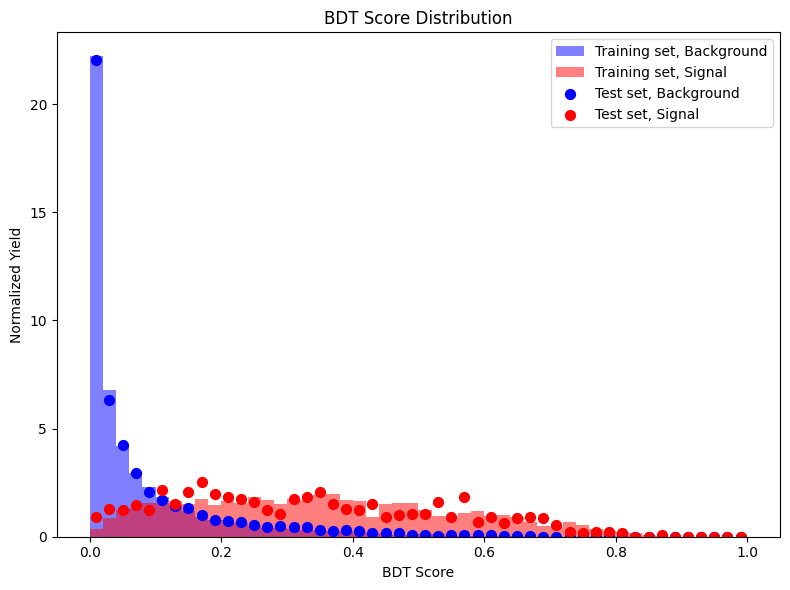

In [168]:
# plot the bdt scores for training and test dataset 

bin_edges = np.linspace(0, 1, 51)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bdt_train_score = bdt.predict_proba(X_train)[:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(
    bdt_train_score[y_train == 0],
    bins=bin_edges,
    alpha=0.5,
    label="Training set, Background",
    color="blue",
    density=True,
)

ax.hist(
    bdt_train_score[y_train == 1],
    bins=bin_edges,
    alpha=0.5,
    label="Training set, Signal",
    color="red",
    density=True,
)

bdt_test_score_hist_yield_bkg, _ = np.histogram(
    bdt_test_score[y_test == 0],
    bins=bin_edges,
    density=True,
)
bdt_test_score_hist_yield_sig, _ = np.histogram(
    bdt_test_score[y_test == 1],
    bins=bin_edges,
    density=True,
)

ax.scatter(
    bin_centers,
    bdt_test_score_hist_yield_bkg,
    label="Test set, Background",
    color="blue",
    marker="o",
    s=50,
)
ax.scatter(
    bin_centers,
    bdt_test_score_hist_yield_sig,
    label="Test set, Signal",
    color="red",
    marker="o",
    s=50,
)

ax.set_xlabel("BDT Score")
ax.set_ylabel("Normalized Yield")
ax.set_title("BDT Score Distribution")
ax.legend()

plt.tight_layout()

In [169]:
bdt_test_score = bdt.predict_proba(X_test)[:, 1]
print(f"BDT ROC AUC: {roc_auc_score(y_true=y_test, y_score=bdt_test_score):.4f}")

BDT ROC AUC: 0.8887
